<a href="https://www.kaggle.com/code/hamidjazayeriy/breast-cancer-detection-lymphoma-pytorch-acc-88?scriptVersionId=185016474" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [71]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


from sklearn.preprocessing import LabelEncoder

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn



# Get the Images path

In [72]:
for dirname, _, filenames in os.walk('../'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))         

../MiniVGG.pt
../lib/kaggle/gcp.py
../input/lymphoma-subtype-classification-fl-vs-cll/Y.npy
../input/lymphoma-subtype-classification-fl-vs-cll/X.npy
/kaggle/input/lymphoma-subtype-classification-fl-vs-cll/Y.npy
/kaggle/input/lymphoma-subtype-classification-fl-vs-cll/X.npy


# Import Images

In [73]:
x_images = np.load('../input/lymphoma-subtype-classification-fl-vs-cll/X.npy')  

y_images = np.load('../input/lymphoma-subtype-classification-fl-vs-cll/Y.npy')   

print('Input images shape =', x_images.shape)
print('Labels shape =', y_images.shape)

Input images shape = (5547, 50, 50, 3)
Labels shape = (5547,)


# Explore Numpy Images

Total Benign  images: 2759
Total Malignant  images: 2788


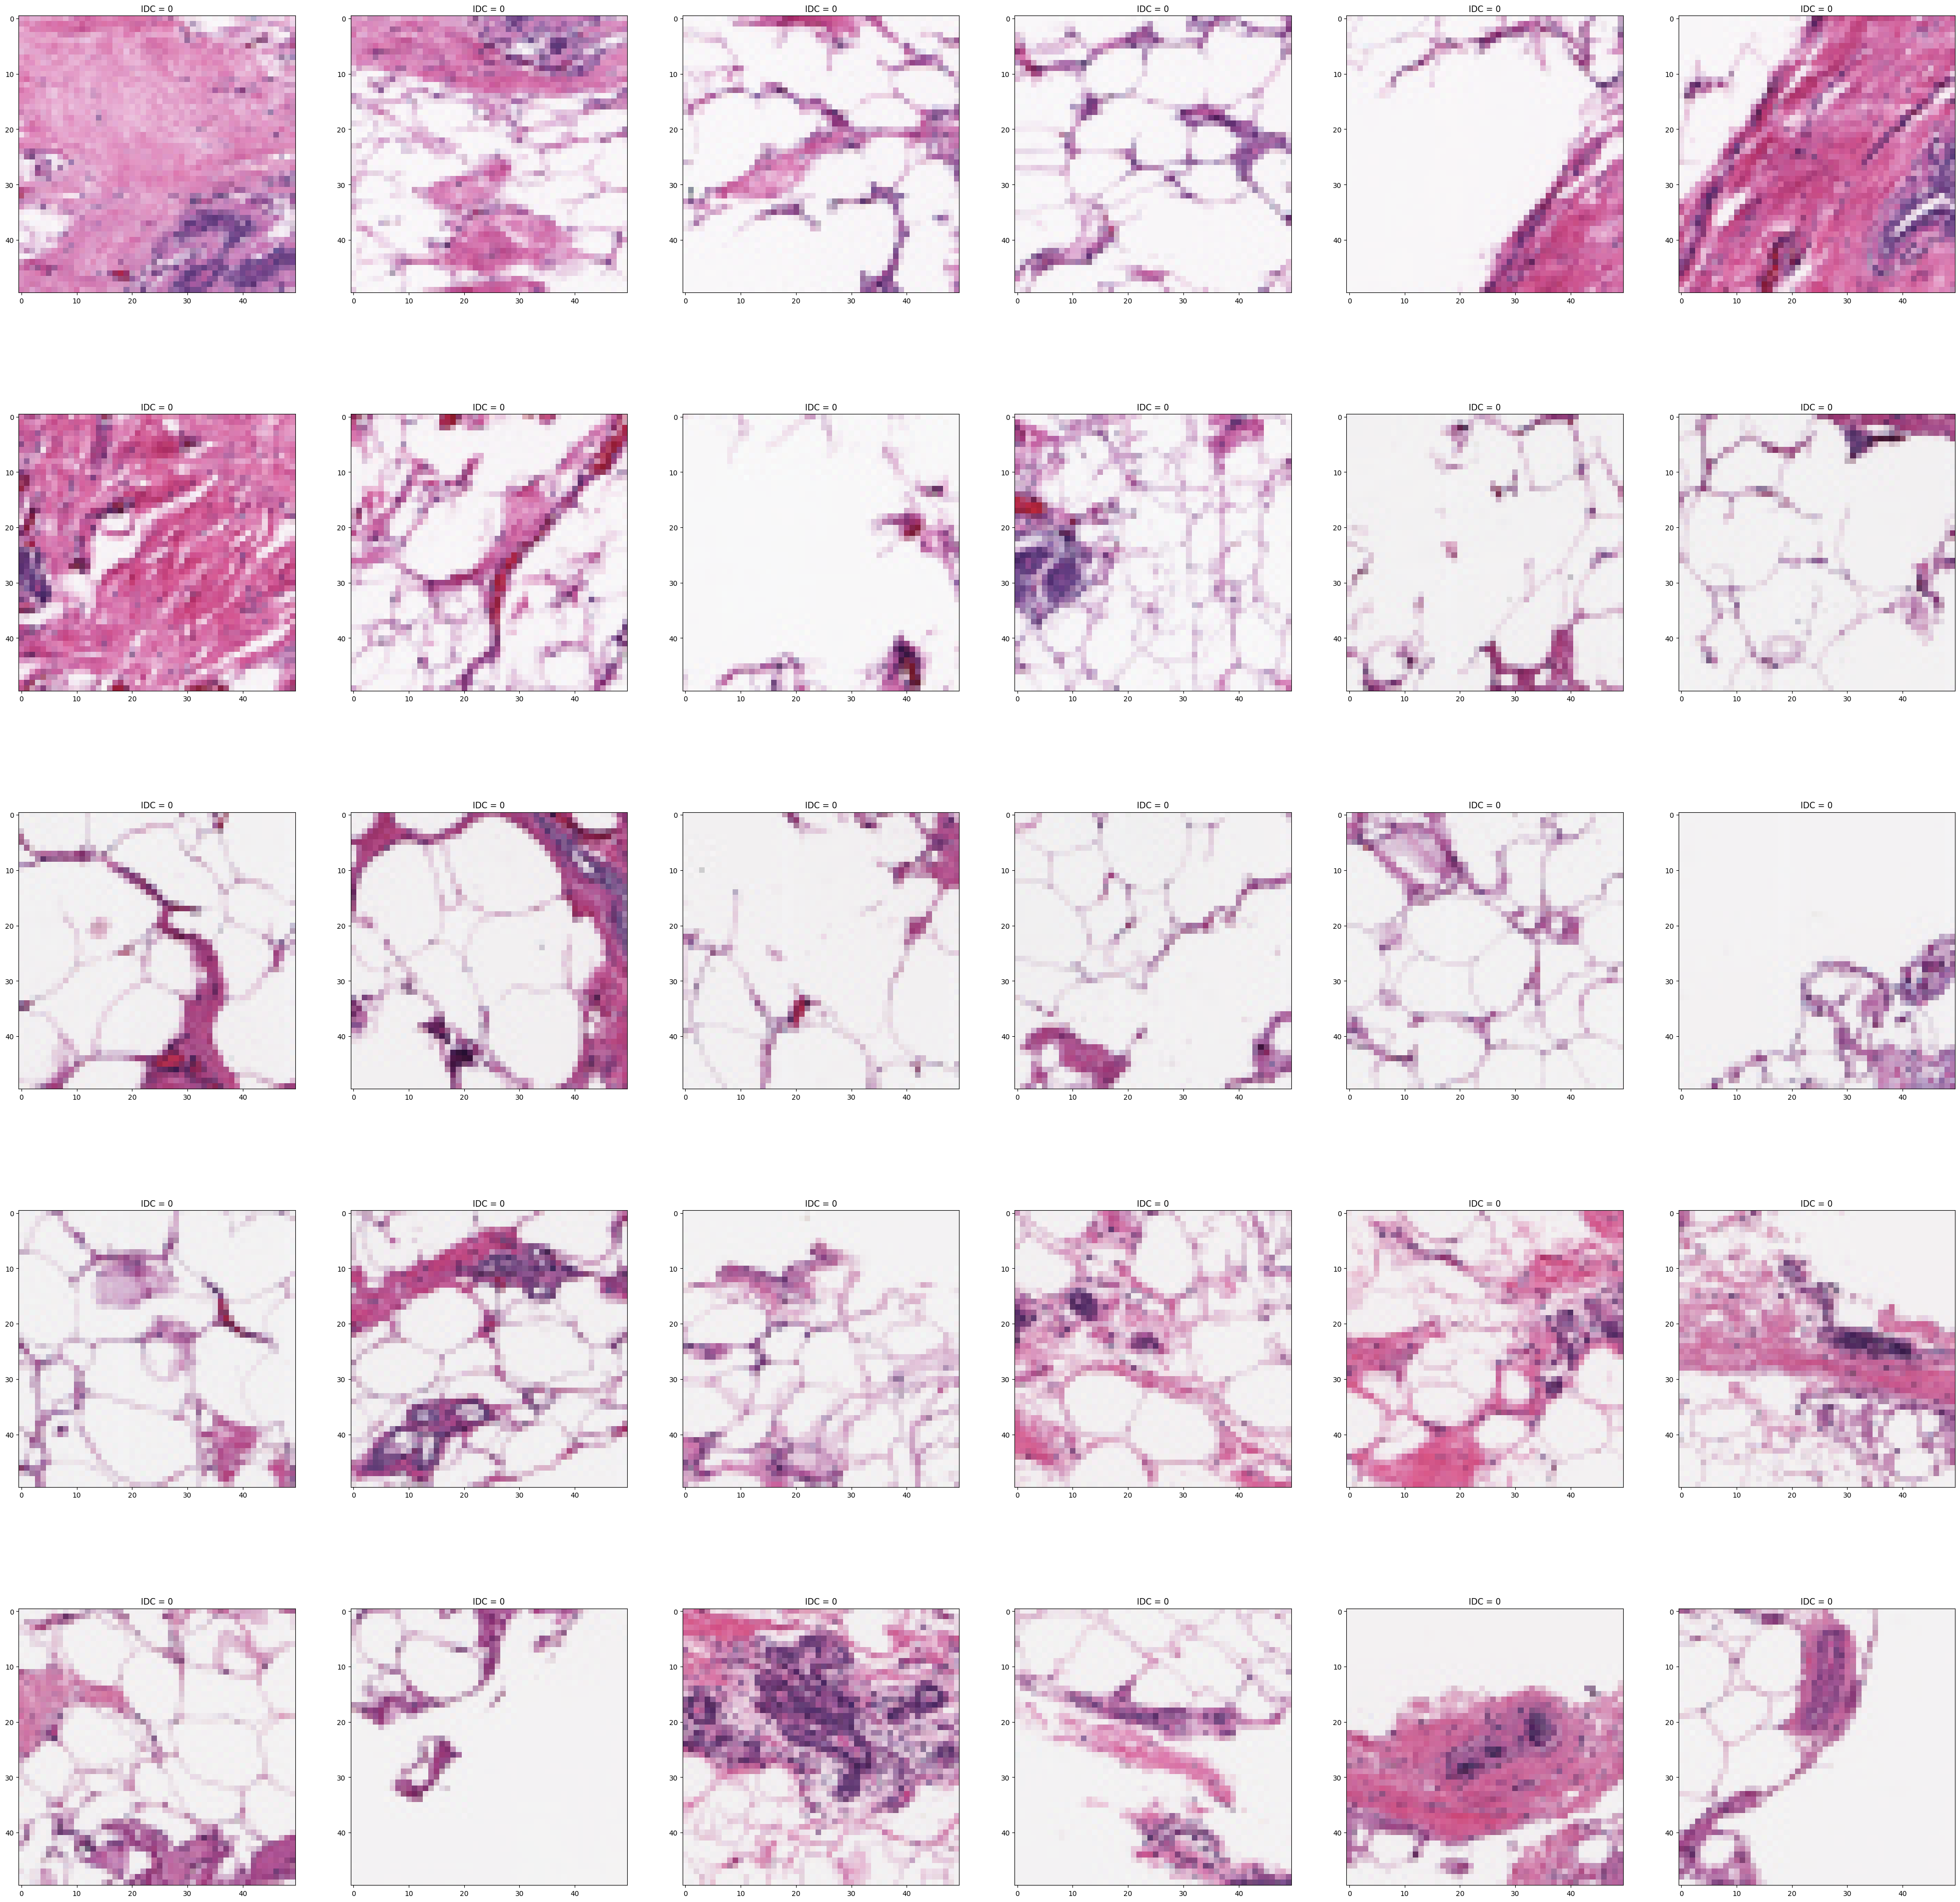

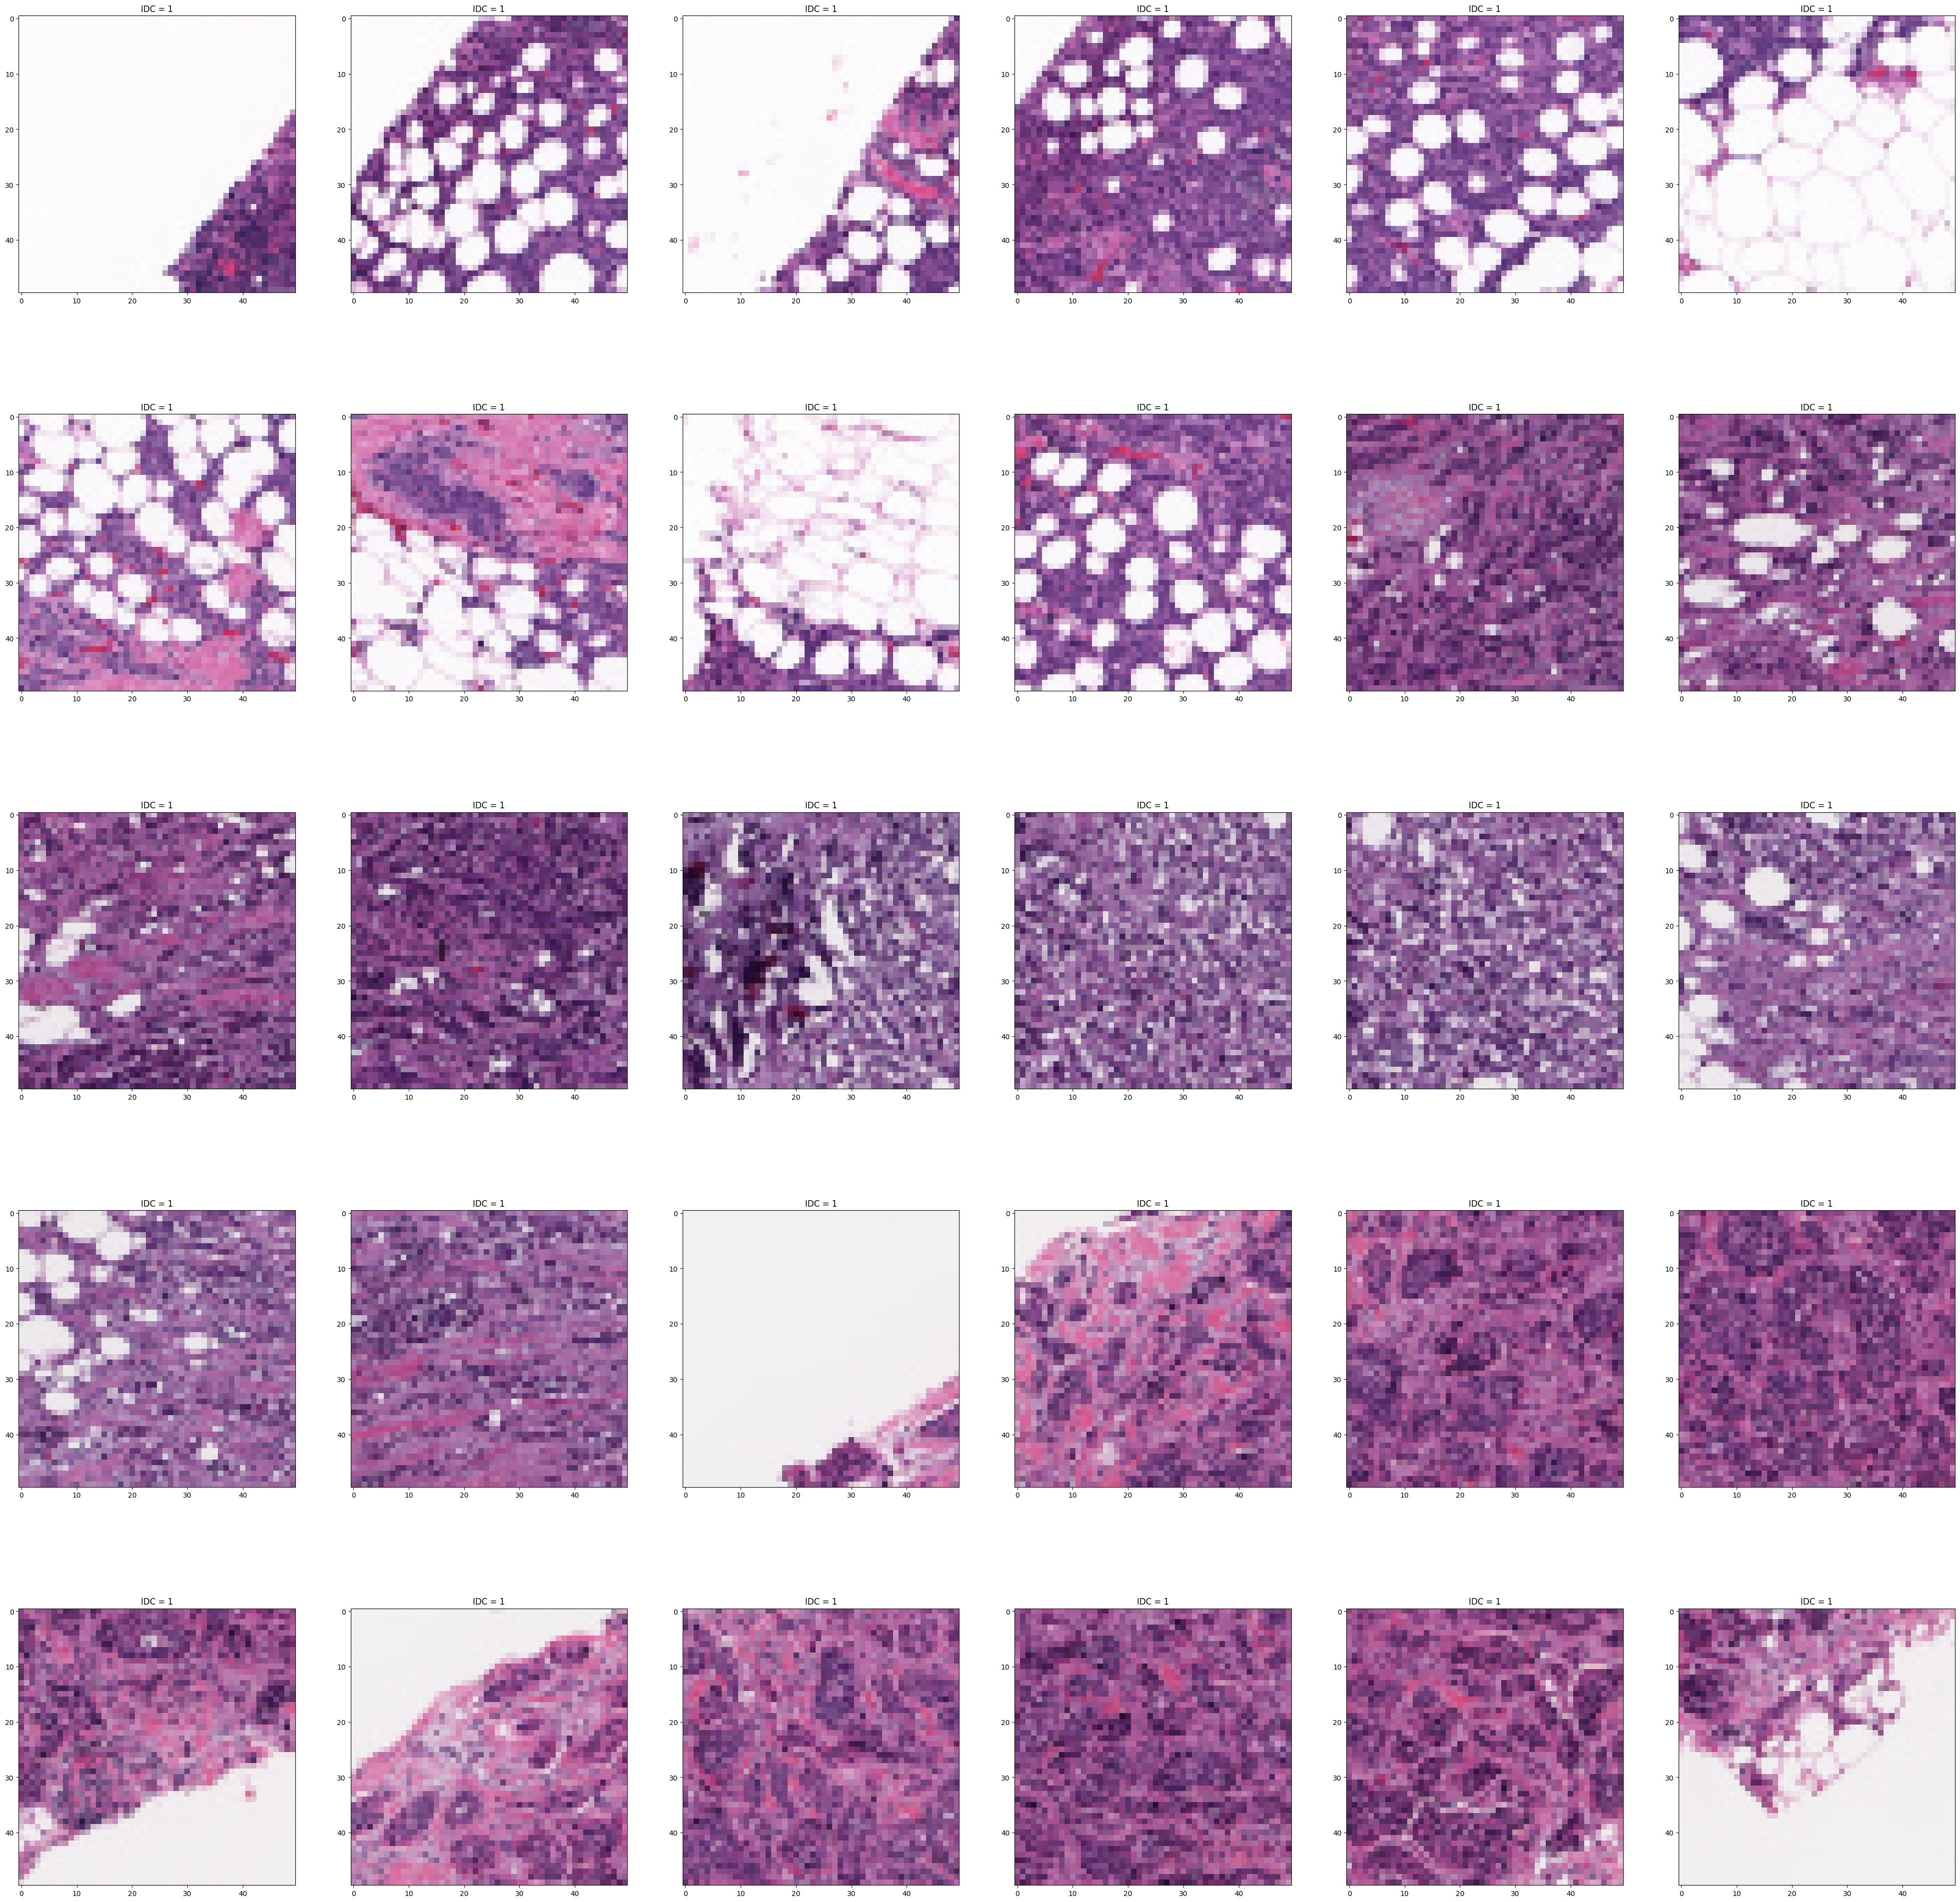

In [74]:
## plot some images  

imgs_0 = x_images[y_images == 0] # 0 = no cancer
imgs_1 = x_images[y_images == 1] # 1 = cancer

print("Total Benign  images:", len(imgs_0))
print("Total Malignant  images:", len(imgs_1))

#plt.figure(figsize=(5,5))
#plt.title(f'IDC = {y_images[127]}')
#plt.imshow(x_images[127])
    
row = 5
col = 6
N = row * col
# plot some images with no cancer
plt.figure(figsize=(50,50))
for i in range(N):
    plt.subplot(row,col,i+1)
    plt.title(f'IDC = 0')
    plt.imshow(imgs_0[i])    
    
    
# plot some images with cancer
plt.figure(figsize=(50,50))
for i in range(N):
    plt.subplot(row,col,i+1)
    plt.title(f'IDC = 1')
    plt.imshow(imgs_1[i])    

   

# Convert Numpy Image to Tensor image

In [75]:
x_images = np.load('../input/lymphoma-subtype-classification-fl-vs-cll/X.npy')  
y_images = np.load('../input/lymphoma-subtype-classification-fl-vs-cll/Y.npy')  

imagesTensor = torch.from_numpy(x_images)
labelsTensor = torch.from_numpy(y_images)

print("labels dim: ", labelsTensor.shape)

# images are in form of (image_id, H, W, C). should be like (image_id, C, H, W) channells first
print("Old dim: ", imagesTensor.shape)
imagesTensor = torch.permute(imagesTensor, (0, 3, 1, 2))
print("New dim: ", imagesTensor.shape)


labels dim:  torch.Size([5547])
Old dim:  torch.Size([5547, 50, 50, 3])
New dim:  torch.Size([5547, 3, 50, 50])


# Normalize Images

In [76]:
# concerintg [0, 255] to [0, 1]
imagesTensor = imagesTensor / imagesTensor.max()

# Lables one-hot encoding

In [77]:
encoder=LabelEncoder()
labelsTensor = encoder.fit_transform(labelsTensor)
print("class Labels :", encoder.classes_)

class Labels : [0 1]


# Define Dataset for Images and Data Loader

In [78]:
# Define a custom dataset class inheriting from Dataset
class ImageDataset(Dataset):
  def __init__(self, images, labels, transform=None):
    super(ImageDataset, self).__init__()  # Explicitly call superclass constructor
#    self.images_path =     
    self.images = images
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = self.images[idx]
    label = self.labels[idx]    
    if self.transform:
        image = self.transform(image)  # Apply transformation if available


    return image, label


# Numpy images should convert to PIL images and than from PIL thay can be converted to Tensor
#    transforms.RandomRotation(degrees=(-30, 30)),
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])
 

# Create the dataset
main_dataset = ImageDataset(imagesTensor, labelsTensor, transform=transform)

len(main_dataset)


5547

# Upsample the dataset by roataing images

In [79]:
class AugmentedDataset(Dataset):
    def __init__(self, original_dataset, transform=None):
        super(AugmentedDataset, self).__init__()  # Explicitly call superclass constructor        
        self.original_dataset = original_dataset
        self.transform = transform
        self.augmented_data = []  # List to store augmented images and labels

        # Apply random rotations to each image in the original dataset
        for image, label in self.original_dataset:
            for angle in range(-45, 46, 15):  # Rotate by -45, -30, -15,... ,15, 30, 45 degrees
                rotated_img = transforms.functional.rotate(image, angle)
                self.augmented_data.append((rotated_img, label))

    def __len__(self):
      # Original size + augmented size
        return len(self.original_dataset) + len(self.augmented_data)

    def __getitem__(self, idx):
        if idx < len(self.original_dataset):
            image, label = self.original_dataset[idx]
        else:
           # Access augmented data (offset index by original dataset size)
            idx -= len(self.original_dataset)
            image, label = self.augmented_data[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [80]:
#dataset = main_dataset 
dataset = AugmentedDataset(main_dataset, transform=None)
len(dataset)

44376

# Create DataLoaders for training and testing

In [81]:
# Split the dataset into training and validation sets (e.g., 80%/20%)
train_ratio = 0.8
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


# Create DataLoaders for training and testing
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=1)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=1)


len(train_dataloader), len(test_dataloader)


(555, 139)

# Defining deep learning blocks

In [82]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)     
        self.dropout = nn.Dropout2d(p=0.2)   

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        return x

    
"""
class ChannelAttentionBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttentionBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
        self.fc1 = nn.Linear(in_channels, in_channels // reduction_ratio)  # Reduce dimensionality
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction_ratio, in_channels)  # Expand dimensionality
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Squeeze: Global Average Pooling
        u = self.avg_pool(x)

        #u = u.view(x.size(0), -1)  # Flatten u before FC layer

        # Excitation: FC layers with ReLU
        z = self.fc1(u)
        z = self.relu(z)
        z = self.fc2(z)
        s = self.sigmoid(z)

        # Scale: Attention weights
        v = x * s

        return v    



class NonLocalAttentionBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=8):
        super(NonLocalBlock, self).__init__()

        self.in_channels = in_channels
        self.reduction_ratio = reduction_ratio

        self.conv_query = nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1, bias=False)
        self.conv_key = nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1, bias=False)
        self.conv_value = nn.Conv2d(in_channels, in_channels, kernel_size=1, bias=False)
        self.conv_out = nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1, bias=False)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        batch_size, in_channels, height, width = x.size()

        # Apply convolutions to get query, key, and value features
        query = self.conv_query(x).view(batch_size, -1, height * width)  # Flatten spatial dimensions
        key = self.conv_key(x).view(batch_size, -1, height * width)
        value = self.conv_value(x).view(batch_size, in_channels, height * width)

        # Calculate attention scores
        scores = torch.bmm(query.transpose(1, 2), key)  # Batch matrix multiplication
        scores = scores / (height * width)  # Normalize scores by spatial dimensions

        # Apply softmax for attention weights
        attention_weights = self.softmax(scores)

        # Context vector
        context = torch.bmm(attention_weights, value)  # Batch matrix multiplication
        context = context.view(batch_size, in_channels, height, width)

        # Output
        output = self.conv_out(context) + x  # Residual connection

        return output


"""


'\nclass ChannelAttentionBlock(nn.Module):\n    def __init__(self, in_channels, reduction_ratio=16):\n        super(ChannelAttentionBlock, self).__init__()\n        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling\n        self.fc1 = nn.Linear(in_channels, in_channels // reduction_ratio)  # Reduce dimensionality\n        self.relu = nn.ReLU(inplace=True)\n        self.fc2 = nn.Linear(in_channels // reduction_ratio, in_channels)  # Expand dimensionality\n        self.sigmoid = nn.Sigmoid()\n\n    def forward(self, x):\n        # Squeeze: Global Average Pooling\n        u = self.avg_pool(x)\n\n        #u = u.view(x.size(0), -1)  # Flatten u before FC layer\n\n        # Excitation: FC layers with ReLU\n        z = self.fc1(u)\n        z = self.relu(z)\n        z = self.fc2(z)\n        s = self.sigmoid(z)\n\n        # Scale: Attention weights\n        v = x * s\n\n        return v    \n\n\n\nclass NonLocalAttentionBlock(nn.Module):\n    def __init__(self, in_channels,

# Impelementing mini-VGG model

In [83]:
class MiniVGG(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(MiniVGG, self).__init__()

        # Define convolutional blocks 
        self.conv1 = ConvBlock(in_channels, 64)  # (50 // 2) x (50 // 2) = 25x25 pixels
        self.conv2 = ConvBlock(64, 128) # (25 // 2) x (25 // 2) = 12x12 #  pixels
        self.conv3 = ConvBlock(128, 256)  #  (12 // 2) x (12 // 2) = 6x6 pixels

        # Define the fully connected layers
        self.fc = nn.Sequential(
          nn.Linear(in_features=256 * 6 * 6, out_features=256),
          nn.ReLU(inplace=True),
          nn.Dropout(p=0.5),       
          nn.Linear(256, 128),
          nn.ReLU(inplace=True),
          nn.Dropout(p=0.5),       
          nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Pass the input through the convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Flatten the features before feeding them to the fully connected layers
        x = x.view(x.size(0), -1)  # Flatten the tensor

        # Pass the flattened features through the fully connected layers
        x = self.fc(x)

        x = nn.functional.log_softmax(x, dim=1)# consider multi_class classification, even for binary classification
        return x

# Creating the model

In [84]:
## Having input channels (e.g., 3 for RGB images) and num_classes (number of categories)

#model = MiniVGGchannelAttention(in_channels=3, num_classes=2)

model = MiniVGG(in_channels=3, num_classes=2)


#model


# Visualizing the model

In [85]:
"""

!pip install torchviz
from torchviz import make_dot

#x = torch.zeros(1, 3, 50, 50, dtype=torch.float, requires_grad=False)
#out = model(x)
#make_dot(out) 

for images, labels in train_dataloader:
    break
yhat = model(images)
make_dot(yhat, params=dict(list(model.named_parameters()))).render("My_model_Name", format="png")




from matplotlib.image import imread

plt.figure(figsize=(25,25))
im = imread('My_model_Name.png')  
plt.imshow(im) 

"""


'\n\n!pip install torchviz\nfrom torchviz import make_dot\n\n#x = torch.zeros(1, 3, 50, 50, dtype=torch.float, requires_grad=False)\n#out = model(x)\n#make_dot(out) \n\nfor images, labels in train_dataloader:\n    break\nyhat = model(images)\nmake_dot(yhat, params=dict(list(model.named_parameters()))).render("My_model_Name", format="png")\n\n\n\n\nfrom matplotlib.image import imread\n\nplt.figure(figsize=(25,25))\nim = imread(\'My_model_Name.png\')  \nplt.imshow(im) \n\n'

In [86]:
# Common choices for image classification:
criterion = nn.CrossEntropyLoss()  # For multi-class classification
#criterion = nn.BCEWithLogitsLoss()  # For binary-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate (lr) as needed

In [87]:
def train(model, dataloader, criterion, optimizer, num_epochs=3):
    """
   Trains a deep learning model using a dataloader for images.

   Args:
      model (torch.nn.Module): The deep learning model to train.
      dataloader (torch.utils.data.DataLoader): The dataloader containing training data.
      criterion (torch.nn.Module): The loss function to use for training.
      optimizer (torch.optim): The optimizer to use for updating model parameters.
      num_epochs (int, optional): The number of epochs to train for. Defaults to 10.
   Returns:
      None
     """        
    # Set the model to training mode 
    model.train()  
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to GPU if available
    
    train_loss_history = []
    
    for epoch in range(num_epochs):
        #print(f'Starting epoch {epoch+1}/{num_epochs}')
        running_loss = 0.0

        for (images, labels) in dataloader:
            images, labels = images.to(device), labels.to(device)  # Move data to device
          
            # Clear gradients from previous iteration
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)       
            loss = criterion(outputs, labels)
            running_loss += loss.item()  # Accumulate loss

            # Backward pass and parameter update
            loss.backward()
            optimizer.step()

        # Print training loss at the end of each epoch
        avg_epoch_loss = running_loss / len(dataloader)
        train_loss_history.append(avg_epoch_loss)
        if epoch%5 == 0:
            print(f'Epoch {epoch+1} - Training loss: {avg_epoch_loss:.5f}')

    print('Training complete!')
    print(f'Training loss: {avg_epoch_loss:.5f}')
    return train_loss_history


In [88]:
train_loss_history = train(model, train_dataloader, criterion, optimizer, num_epochs=128)

Epoch 1 - Training loss: 0.56427
Epoch 6 - Training loss: 0.48736
Epoch 11 - Training loss: 0.46045
Epoch 16 - Training loss: 0.43672
Epoch 21 - Training loss: 0.41134
Epoch 26 - Training loss: 0.38523
Epoch 31 - Training loss: 0.35304
Epoch 36 - Training loss: 0.32381
Epoch 41 - Training loss: 0.29885
Epoch 46 - Training loss: 0.27454
Epoch 51 - Training loss: 0.25765
Epoch 56 - Training loss: 0.23810
Epoch 61 - Training loss: 0.22397
Epoch 66 - Training loss: 0.21372
Epoch 71 - Training loss: 0.19782
Epoch 76 - Training loss: 0.18819
Epoch 81 - Training loss: 0.17839
Epoch 86 - Training loss: 0.17243
Epoch 91 - Training loss: 0.16835
Epoch 96 - Training loss: 0.16011
Epoch 101 - Training loss: 0.15210
Epoch 106 - Training loss: 0.14434
Epoch 111 - Training loss: 0.14436
Epoch 116 - Training loss: 0.14051
Epoch 121 - Training loss: 0.13437
Epoch 126 - Training loss: 0.13703
Training complete!
Training loss: 0.12445


# Save the trained model

In [93]:
torch.save(model.state_dict(), '../MiniVGG.pt')


# Load the trained model

In [90]:
model_path = '../MiniVGG.pt'
# Load the model state dictionary
loaded_model_state = torch.load(model_path)

# Create a new model instance with the same architecture as the saved model
loaded_model = MiniVGG(in_channels=3, num_classes=2)

# Load the saved state dictionary into the new model
loaded_model.load_state_dict(loaded_model_state)

<All keys matched successfully>

# Test Method

In [91]:
def test_model(model, test_loader, criterion):
    """
  Tests the loaded model on a given test data loader using the provided loss function.

  Args:
      model (nn.Module): Loaded model instance.
      test_loader (DataLoader): Data loader for test data.
      criterion (nn.Module): Loss function for calculating performance.

  Returns:
      float: Average loss on the test data.
    """
    # Set the model to evaluation mode  
    model.eval()    
    
    # Initialize variables for tracking performance
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for images, labels in test_loader:
          # Pass the test images through the model
            outputs = model(images)

          # Calculate the loss
            loss = criterion(outputs, labels)

            predicted = torch.max(outputs.data, 1)[1]
            total_correct +=  (predicted == labels).sum()
            
          # Accumulate loss and total samples
            total_loss += loss.item() * labels.size(0)  # Multiply by batch size
            total_samples += labels.size(0)

    # Calculate average loss
    average_loss = total_loss / total_samples
    accuracy = 100 * total_correct / total_samples
  
    return accuracy, average_loss



# Test the model

In [92]:
acc, avg_loss = test_model(loaded_model, test_dataloader, criterion)

print('Test Accuracy: % {:.4f}'.format(acc))
print('Test Average Loss: {:.4f}'.format(avg_loss))


Test Accuracy: % 88.1366
Test Average Loss: 0.3274
